In [1]:
import numpy as np
from scipy.integrate import odeint,solve_ivp
import torch
import myplot
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
import torch.nn as nn
import praktikum
import torch.nn.functional as F
from itertools import chain
device=myplot.try_gpu()

In [2]:
def ode(y, t, gamma):
    S, I, R, D, N = y
    mu = 0.078 * np.exp(t / 150 * np.log(0.005 / 0.078))
    beta = 0.3 * np.exp(t/ 150 * np.log(0.5))
    dSdt = -beta * S * I / N
    dIdt = beta * S * I / N - (gamma + mu) * I
    dRdt = gamma * I
    dDdt = mu * I
    dNdt = -mu * I
    return [dSdt, dIdt, dRdt, dDdt, dNdt]

In [3]:
y0 = torch.tensor([999000., 1000., 0., 0., 1000000.])
T=150 #more data may be better
step=1
beta=lambda x:0.3*np.exp(x / T * np.log(0.5))
mu=lambda x:0.078*np.exp(x / T * np.log(0.005/0.078))
t =torch.arange(0.,T,step)
real=beta(t),mu(t)
gamma = 0.1
simulation = torch.tensor(odeint(ode, y0, t, args=(gamma,)))
dSdt, dIdt, dRdt, dDdt, dNdt = ode(simulation.T, t, gamma)
weifen=torch.cat((dSdt.reshape(-1,1),dIdt.reshape(-1,1),dRdt.reshape(-1,1),dDdt.reshape(-1,1),dNdt.reshape(-1,1)),dim=1)
tau = 2
features = torch.zeros((int(T/step) - tau+1, tau))
for i in range(tau):
    features[:, i] = t[i: int(T/step) - tau + i+1]

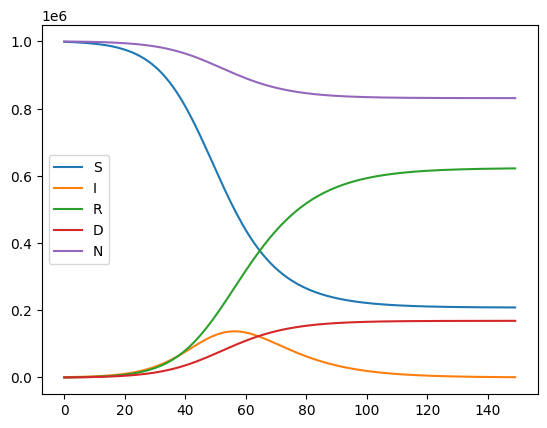

In [7]:
myplot.woplot(simulation,t,display_R=True,type='solid')

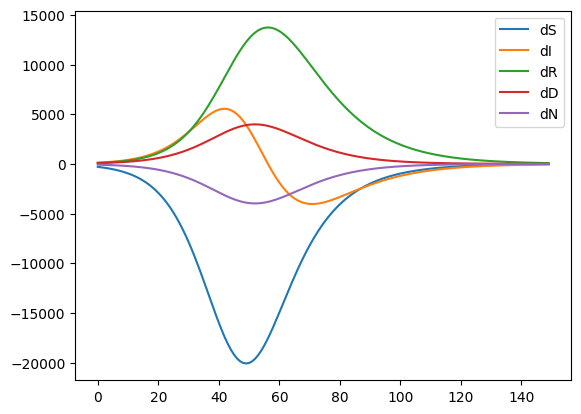

In [8]:
myplot.woplot(weifen,t,label=1,display_R=True,type='solid')

In [10]:
def simple_with_time(data_with_time,scale, tau, batch_size, train_ratio, isshuffle=False,  noise=False, reverse=False):
    data_with_time[:,tau:]=data_with_time[:,tau:]/scale
    if noise:
        data_with_time[:,1:] += 0.005 * torch.randn(data_with_time[:,1:].shape)

    if reverse:
        data_with_time = torch.flip(data_with_time, [0])

    total_size = len(data_with_time)
    train_size = int(total_size * train_ratio)

    train_dataset = TensorDataset(
        data_with_time[:train_size, :tau+5].type(torch.float32),
        data_with_time[:train_size, tau+5:].type(torch.float32)
    )
    test_dataset = TensorDataset(
        data_with_time[train_size:, :tau+5].type(torch.float32),
        data_with_time[train_size:, tau+5:].type(torch.float32)
    )
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=isshuffle)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, test_loader

In [11]:
total=torch.cat((features,simulation[tau-1:,:],weifen[tau-1:,:]),dim=1)
train_data,test_data=simple_with_time(total,1000,tau,20,0.7,isshuffle=False,noise=False,reverse=False) # dont add any noise
c=0
for x,y in train_data:
    print(x)
    if c==2:
        break
    c+=1

tensor([[0.0000e+00, 1.0000e+00, 9.9868e+02, 1.1294e+00, 1.0634e-01, 8.2174e-02,
         9.9992e+02],
        [1.0000e+00, 2.0000e+00, 9.9832e+02, 1.2755e+00, 2.2644e-01, 1.7330e-01,
         9.9983e+02],
        [2.0000e+00, 3.0000e+00, 9.9792e+02, 1.4403e+00, 3.6206e-01, 2.7433e-01,
         9.9973e+02],
        [3.0000e+00, 4.0000e+00, 9.9747e+02, 1.6263e+00, 5.1521e-01, 3.8635e-01,
         9.9961e+02],
        [4.0000e+00, 5.0000e+00, 9.9697e+02, 1.8361e+00, 6.8812e-01, 5.1053e-01,
         9.9949e+02],
        [5.0000e+00, 6.0000e+00, 9.9640e+02, 2.0725e+00, 8.8331e-01, 6.4817e-01,
         9.9935e+02],
        [6.0000e+00, 7.0000e+00, 9.9576e+02, 2.3390e+00, 1.1036e+00, 8.0070e-01,
         9.9920e+02],
        [7.0000e+00, 8.0000e+00, 9.9504e+02, 2.6391e+00, 1.3522e+00, 9.6969e-01,
         9.9903e+02],
        [8.0000e+00, 9.0000e+00, 9.9423e+02, 2.9769e+00, 1.6327e+00, 1.1569e+00,
         9.9884e+02],
        [9.0000e+00, 1.0000e+01, 9.9333e+02, 3.3570e+00, 1.9490e+00, 1.36

In [19]:
class ParameterNet(nn.Module):
    def __init__(self,tau):
        super(ParameterNet, self).__init__()
        self.lstm = nn.LSTM(input_size=tau, hidden_size=64, num_layers=1, batch_first=True)  #add lstm
        self.para = nn.Sequential(
            nn.Linear(64,20),
            # nn.BatchNorm1d(20),
            nn.ReLU(),
            nn.Linear(20, 20),
            # nn.BatchNorm1d(20),
            nn.ReLU(),
            nn.Linear(20,1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x,_=self.lstm(x)
        return self.para(x)

In [20]:
class Net(nn.Module):
    def __init__(self,tau):
        super(Net, self).__init__()
        self.tau=tau
        self.beta=ParameterNet(tau)
        self.mu=ParameterNet(tau)

    def forward(self, x):
        tau=self.tau
        t=x[:,:tau]
        S=x[:,tau].reshape(-1,1)
        I=x[:,tau+1].reshape(-1,1)
        N=x[:,tau+4].reshape(-1,1)
        pre_beta=self.beta(t)
        pre_mu=self.mu(t)
        dS=-pre_beta*S*I/N
        # dI=-dS-(pre_mu+0.1)*I
        dD=pre_mu*I
        return dS,dD

In [21]:
net = Net(tau)
def init_weights(m):
        if type(m)==nn.Linear:
            nn.init.kaiming_uniform_(m.weight) #since use the relu
net.apply(init_weights)
criterion = nn.MSELoss()

In [22]:
def train(net,device,train,test,optimizer,criterion,epoch):
    net.to(device)
    train_loss_list = []  # 保存训练集损失
    test_loss_list = []  # 保存验证集损失
    optimizer_beta=optimizer[0]
    optimizer_mu=optimizer[1]
    for i in range(epoch):
        net.train()
        train_loss = 0
        for X_train,y_train in train:
            X_train,y_train=X_train.to(device),y_train.to(device)
            p=net(X_train)
            optimizer_beta.zero_grad()
            loss1=criterion(p[0],y_train[:,0:1])
            loss1.backward()
            optimizer_beta.step()

            optimizer_mu.zero_grad()
            loss2=criterion(p[1],y_train[:,3:4])
            loss2.backward()
            optimizer_mu.step()

            train_loss += loss1.item()
            train_loss += loss2.item()

        net.eval()
        test_loss = 0
        with torch.no_grad():
            for X_test, y_test in test:
                X_test, y_test = X_test.to(device), y_test.to(device)
                out = net(X_test)
                loss1=criterion(out[0],y_test[:,0:1])
                loss2=criterion(out[1],y_test[:,3:4])
                test_loss += loss1.item()
                test_loss += loss2.item()

        # 计算平均损失
        avg_train_loss = train_loss / len(train)
        avg_test_loss = test_loss / len(test)

        train_loss_list.append(avg_train_loss)
        test_loss_list.append(avg_test_loss)

        if i%10==0:
            print('Epoch:', i, 'Train loss:', avg_train_loss, 'Test loss:', avg_test_loss)

    plt.plot(train_loss_list,label='train')
    plt.plot(test_loss_list,label='test')
    plt.legend()
    return train_loss_list, test_loss_list

Epoch: 0 Train loss: 0.007038137750934463 Test loss: 8.095396939703885e-05
Epoch: 10 Train loss: 0.0007183051503716342 Test loss: 0.00010890001127942621
Epoch: 20 Train loss: 0.0002748874995764557 Test loss: 0.00010624956181951954
Epoch: 30 Train loss: 0.00035830844509140053 Test loss: 0.00010826578242510247
Epoch: 40 Train loss: 0.027646269320636446 Test loss: 0.00011895730494870804
Epoch: 50 Train loss: 0.00029087318817270596 Test loss: 0.00010814752446700975
Epoch: 60 Train loss: 0.00025520798817524337 Test loss: 0.00010504418908870623
Epoch: 70 Train loss: 0.0002499204998305989 Test loss: 0.00010356588366751869
Epoch: 80 Train loss: 0.0003239651298751293 Test loss: 9.976672239038938e-05
Epoch: 90 Train loss: 0.01796550374679858 Test loss: 0.00015402021866369373
Epoch: 100 Train loss: 0.0011221969478943568 Test loss: 0.00010550838427055471
Epoch: 110 Train loss: 0.00025111264494626084 Test loss: 0.0001041115547195659
Epoch: 120 Train loss: 0.00024149325626391752 Test loss: 0.0001021

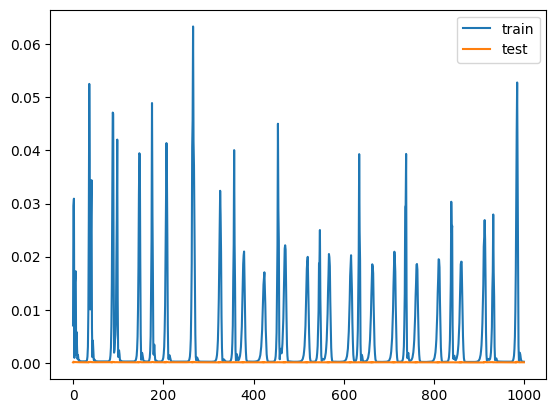

In [29]:
optimizer=[torch.optim.Adam(net.beta.parameters(),lr=0.0002,weight_decay=1e-7),torch.optim.Adam(net.mu.parameters(),lr=0.0002,weight_decay=1e-7)]
train_loss_list, test_loss_list=train(net,device,train_data,test_data,optimizer,criterion,epoch=1000)

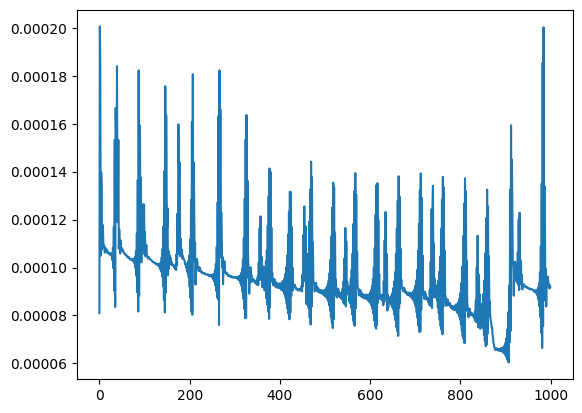

In [30]:
plt.plot(test_loss_list)

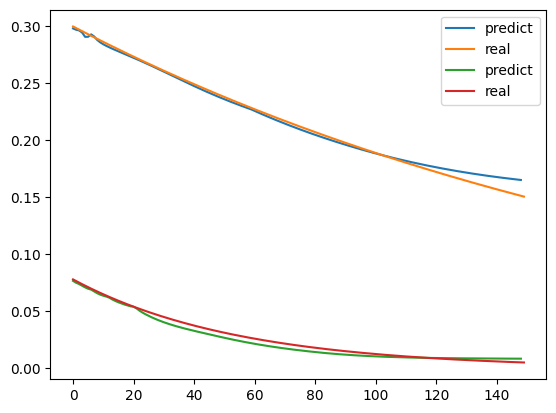

In [31]:
net.to('cpu')
pre_mu=net.mu(features).detach().numpy()
pre_beta=net.beta(features).detach().numpy()
plt.plot(pre_beta,label='predict')
plt.plot(real[0],label='real')
plt.plot(pre_mu,label='predict')
plt.plot(real[1],label='real')
plt.legend()

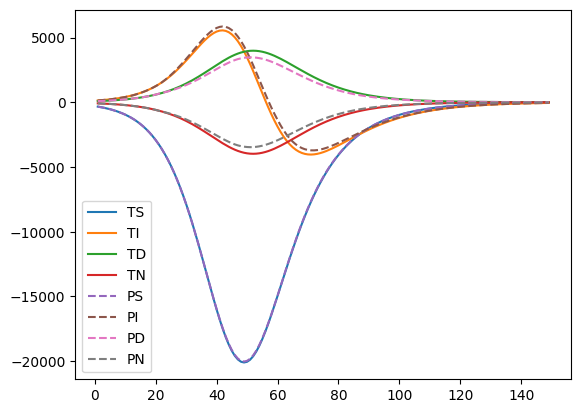

In [32]:
def getbypre(data,beta,mu,tau):
    dS=-torch.tensor(beta).squeeze()*data[:,tau]*data[:,tau+1]/data[:,tau+4]
    dI=-dS-(0.1+torch.tensor(mu).squeeze())*data[:,tau+1]
    dR=0.1*data[:,tau+1]
    dD=torch.tensor(mu).squeeze()*data[:,tau+1]
    dN=-dD
    return torch.cat((dS.unsqueeze(1), dI.unsqueeze(1), dR.unsqueeze(1), dD.unsqueeze(1), dN.unsqueeze(1)), dim=1)
result = getbypre(total,pre_beta,pre_mu,tau)
praktikum.compare_woplot(weifen[tau-1:],result*1000,t[tau-1:])

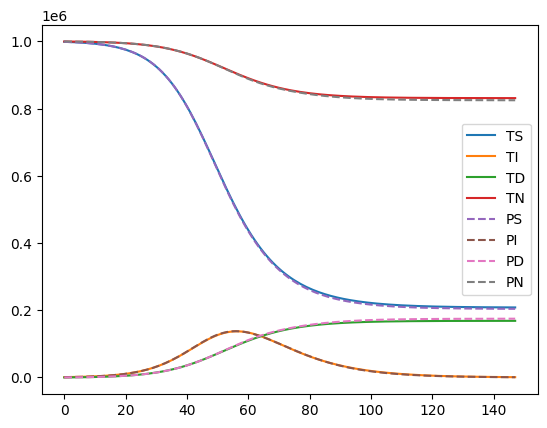

In [43]:
def compare_woplot(true_data, pre_data, t, type='--', label=None, display_R=False):
    if label is None:
        label = ['TS', 'TI', 'TR', 'TD', 'TN']
    else:
        label = ['TdS', 'TdI', 'TdR', 'TdD', 'TdN']
    plt.plot(t, true_data[:, 0], label=label[0], linestyle='solid')
    plt.plot(t, true_data[:, 1], label=label[1], linestyle='solid')
    if display_R:
        plt.plot(t, true_data[:, 2], label=label[2], linestyle='solid')
    plt.plot(t, true_data[:, 3], label=label[3], linestyle='solid')
    plt.plot(t, true_data[:, 4], label=label[4], linestyle='solid')

    if label == ['TS', 'TI', 'TR', 'TD', 'TN']:
        label = ['PS', 'PI', 'PR', 'PD', 'PN']
    elif label == ['TdS', 'TdI', 'TdR', 'TdD', 'TdN']:
        label = ['PdS', 'PdI', 'PdR', 'PdD', 'PdN']
    plt.plot(t, pre_data[:, 0], label=label[0], linestyle=type)
    plt.plot(t, pre_data[:, 1], label=label[1], linestyle=type)
    if display_R:
        plt.plot(t, pre_data[:, 2], label=label[2], linestyle=type)
    plt.plot(t, pre_data[:, 3], label=label[3], linestyle=type)
    plt.plot(t, pre_data[:, 4], label=label[4], linestyle=type)

    plt.legend()
    plt.show()

def pre_para_ode(y, t, gamma, step):
    S, I, R, D, N = y
    beta = pre_beta[int(t/step)]
    mu = pre_mu[int(t/step)]
    dSdt = -beta * S * I / N
    dIdt = -dSdt - (gamma + mu) * I
    dRdt = gamma * I
    dDdt = mu * I
    dNdt = -dDdt
    return [dSdt, dIdt, dRdt, dDdt, dNdt]

def woplot(data, t, type='--', label=None, display_R=False):
    if label is None:
        label = ['S', 'I', 'R', 'D', 'N']
    else:
        label = ['dS', 'dI', 'dR', 'dD', 'dN']
    plt.plot(t, data[:, 0], label=label[0], linestyle=type)
    plt.plot(t, data[:, 1], label=label[1], linestyle=type)
    if display_R:
        plt.plot(t, data[:, 2], label=label[2], linestyle=type)
    plt.plot(t, data[:, 3], label=label[3], linestyle=type)
    plt.plot(t, data[:, 4], label=label[4], linestyle=type)
    plt.legend()
    plt.show()


def pre_ode(beta, mu, T, tau,simulation=None, compare=False, step=1):
    y0 = torch.tensor([999000., 1000., 0., 0., 1000000.])
    gamma = 0.1
    global pre_beta, pre_mu
    pre_beta = beta
    pre_mu = mu
    t = torch.arange(0., T, step)
    t=t[:-tau]
    if compare:
        compare_woplot(simulation[:-tau], odeint(pre_para_ode, y0, t, args=(gamma,step)), t)
    else:
        woplot(odeint(pre_para_ode, y0, t, args=(gamma,)), t, '--')

pre_ode(pre_beta,pre_mu,T,tau,simulation,compare=True,step=step)

In [34]:
pre_beta.dtype

dtype('float32')

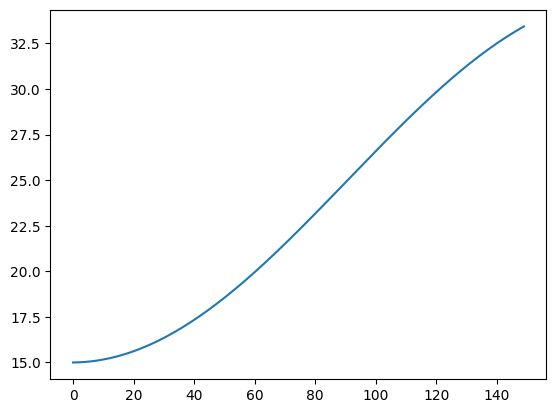

In [45]:
def T(t): # air temperature, input t is time assuming t=0 corresponds to first day of a year
    return 25+10*np.cos((2*np.pi*(t-182))/(365))
plt.plot(T(t))